In [1]:
# ----------------------------------------------------------------------------
#
# TITLE - triaxial_potential_DF.ipynb
# AUTHOR - James Lane
# PROJECT - AST 1501
#
# ----------------------------------------------------------------------------
#
# Docstrings and metadata:
'''
Calculate the actions around the strange features in the triaxial DF
'''

__author__ = "James Lane"

In [2]:
## Imports

## Basic
import numpy as np
import sys, os, pdb
import copy
import time
from tqdm import tqdm_notebook as tqdm_nb

## Plotting
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import animation
from matplotlib import colors
from matplotlib import cm
# import aplpy

## Astropy
from astropy import units as apu

## galpy
from galpy import orbit
from galpy import potential
from galpy import df
from galpy.actionAngle import actionAngleAdiabatic
from galpy.actionAngle import actionAngleStaeckel
from galpy.util import bovy_coords as gpcoords
from galpy.util import bovy_conversion as gpconv

## Add project-specific package. Assume relative location
sys.path.append('../../src/')
import ast1501.potential
import ast1501.util

In [3]:
### Change Jupyter settings

from IPython.core.interactiveshell import InteractiveShell
from IPython.display import Markdown, display

# Matplotlib for notebooks
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# pretty print all cell's output and not just the last one
InteractiveShell.ast_node_interactivity = "all"

# Print using markdown
def printmd(string, color=None):
    colorstr = "<span style='color:{}'>{}</span>".format(color, string)
    display(Markdown(colorstr))

# Meta

## Future work
- Go in depth into the functions that calculate the radial action

## Information
- Galpy notes on the DF: https://galpy.readthedocs.io/en/latest/diskdf.html
- Galpy notes on the actions: https://galpy.readthedocs.io/en/latest/actionAngle.html

# Prepare
Declare the keywords for the analysis, make the potential, and the DF

## Keywords and Functions

In [4]:
### Keywords

# Halo evolution
t_evolve = 10 # Gyr
tform = -9 # Gyr ago
tsteady = 8 # Gyr after tform

# The times over which each orbit will be integrated
times = -np.array([0,t_evolve]) * apu.Gyr

In [5]:
### Function definitions

def gen_vRvT_1D(dvT, dvR, vR_low, vR_hi, vT_low, vT_hi):
    
    # Generate the velocity range
    vR_range = np.arange( vR_low, vR_hi, dvR )
    vT_range = np.arange( vT_low, vT_hi, dvT )

    # Generate the array of distribution function values
    dfp = np.zeros((len(vR_range),len(vT_range)))
    df0 = np.zeros((len(vR_range),len(vT_range)))

    # Output information
    print( str(len(vR_range)*len(vT_range))+' independent velocities' )
    print( str(len(vR_range))+' Between vR=['+str(round(np.amin(vR_range)))+','+str(round(np.amax(vR_range)))+']')
    print( str(len(vR_range))+' Between vR=['+str(round(np.amin(vT_range)))+','+str(round(np.amax(vT_range)))+']')
    print('\n')
    print(vR_range)
    print(vT_range)
    print('\n')
    
    return df0, dfp, vR_range, vT_range
#def

def eval_df(vxvv, times, pot, vR_range, vT_range, df0, dfp):
    
    vxvv_use = copy.deepcopy(vxvv)
    for j in tqdm_nb( range( len(vR_range) ) ):
        for k in range( len(vT_range) ):

            # Make the orbit
            vxvv_use[1] = vR_range[j]*apu.km/apu.s
            vxvv_use[2] = vT_range[k]*apu.km/apu.s
            o = orbit.Orbit(vxvv=vxvv_use)

            # Evaluate the unperturbed distribution function if this is the first run-through    
            df0[j,k] = qdf(o)

            # Now evaluate the perturbed distribution function
            o.integrate(times, pot)
            dfp[j,k] = qdf( o(times[-1]) )
        ###k
    ###j
    
    return df0, dfp
#def

def eval_act(vxvv, times, tripot_grow, qdf_aA, vR_range, vT_range, act0, actp, return_kin=False):
    
    if return_kin:
        end_kin = np.zeros((3,len(vR_range),len(vT_range)))
    ##fi
    
    vxvv_use = copy.deepcopy(vxvv)
    for j in tqdm_nb( range( len(vR_range) ) ):
        for k in range( len(vT_range) ):

            # Make the orbit
            vxvv_use[1] = vR_range[j]*apu.km/apu.s
            vxvv_use[2] = vT_range[k]*apu.km/apu.s
            o = orbit.Orbit(vxvv=vxvv_use)

            # Get the actions, angles and frequencies for the unperturbed orbit
            act0[0,j,k],act0[1,j,k],act0[2,j,k] = qdf_aA(o)

            # Integrate the orbit and evaluate 
            o.integrate(times, tripot_grow)
            actp[0,j,k],actp[1,j,k],actp[2,j,k] = qdf_aA( o(times[-1]) )
            
            if return_kin:
                end_kin[0,j,k] = o.R(times[-1]).value
                end_kin[1,j,k] = o.vR(times[-1]).value
                end_kin[2,j,k] = o.vT(times[-1]).value
            ##fi
        ###k
    ###j
    
    if return_kin:
        return act0, actp, end_kin
    else:
        return act0, actp
    ##ie
#def

def hist_df(df0, dfp, vR_low, vR_hi, vT_low, vT_hi, log=False):
    
    ## Make the original distribution function
    img_arr1 = np.rot90( df0/np.max(df0) )
    if log:
        img1 = ax1.imshow(np.log10(img_arr1), interpolation='nearest',
                            extent=[vR_low, vR_hi, vT_low, vT_hi],
                            cmap='viridis', vmax=0, vmin=-3)
        cbar1 = plt.colorbar(img1, ax=ax1)
        cbar1.set_label(r'$\log [f/f_{max}]$', fontsize=16)
    else:
        img1 = ax1.imshow(img_arr1, interpolation='nearest',
                            extent=[vR_low, vR_hi, vT_low, vT_hi],
                            cmap='viridis', vmax=1, vmin=0)
        cbar1 = plt.colorbar(img1, ax=ax1)
        cbar1.set_label(r'$f/f_{max}$', fontsize=16)
    ##ie

    # Decorate
    ax1.set_xlabel(r'$V_{R}$ [km/s]', fontsize=14)
    ax1.set_ylabel(r'$V_{\phi}$ [km/s]', fontsize=14)
    ax1.set_title('MWPotential2014')


    ## Make the triaxial distribution function
    img_arr2 = np.rot90( dfp/np.max(dfp) )
    
    if log:
        img2 = ax2.imshow(np.log10(img_arr2), interpolation='nearest',
                            extent=[vR_low, vR_hi, vT_low, vT_hi],
                            cmap='viridis', vmax=0, vmin=-3)
        cbar2 = plt.colorbar(img2, ax=ax2)
        cbar2.set_label(r'$\log [f/f_{max}]$', fontsize=16)
    else:
        img2 = ax2.imshow(img_arr2, interpolation='nearest',
                            extent=[vR_low, vR_hi, vT_low, vT_hi],
                            cmap='viridis', vmax=1, vmin=0)
        cbar2 = plt.colorbar(img2, ax=ax2)
        cbar2.set_label(r'$f/f_{max}$', fontsize=16)

    # Decorate
    ax2.set_xlabel(r'$V_{R}$ [km/s]', fontsize=14)
    ax2.set_ylabel(r'$V_{\phi}$ [km/s]', fontsize=14)
    ax2.set_title('Triaxial')

    return fig, ax1, ax2, cbar1, cbar2
#def

def hist_act(act, vR_low, vR_hi, vT_low, vT_hi, cbar_labels):
    
    # Loop over the three actions, then over perturbed and unperturbed.
    for i in range(3):
        
        img_arr = np.rot90( act[i] )
        img = axs[i].imshow(img_arr, interpolation='nearest',
            extent=[vR_low, vR_hi, vT_low, vT_hi],
            cmap='Blues')
        
        cbar = plt.colorbar(img, ax=axs[i])
        cbar.set_label(cbar_labels[i])
        axs[i].set_ylabel(r'$V_{\phi}$ [km/s]')
        axs[i].set_xlabel(r'$V_{R}$ [km/s]')
        ###j
    ###i
    return fig, axs
#def

## Potential and Distribution Function

In [6]:
### Make MWPotential2014
mwpot = potential.MWPotential2014

### Make the triaxial halo
trihalo = ast1501.potential.make_MWPotential2014_triaxialNFW(halo_b=2.0, halo_phi=0.0, halo_c=1.0)

### Make MWPotential2014 with DSW around the halo and triaxial halo
tripot_grow = ast1501.potential.make_tripot_dsw(trihalo=trihalo, tform=tform, tsteady=tsteady)
potential.turn_physical_off(tripot_grow)

In [8]:
## Make the quasi-isothermal distribution function. See notebook #3 for the velocity scales.

# Velocity dispersions in km/s
sigma_vR = 46/1.5
sigma_vT = 40/1.5
sigma_vZ = 28/1.5

# Action angle coordinates and the DF
qdf_aA= actionAngleAdiabatic(pot=potential.MWPotential2014, c=True)
qdf = df.quasiisothermaldf( hr= 2*apu.kpc,
                            sr= sigma_vR*(apu.km/apu.s),
                            sz= sigma_vZ*(apu.km/apu.s),
                            hsr= 9.8*(apu.kpc),
                            hsz= 7.6*(apu.kpc),
                            pot= potential.MWPotential2014, 
                            aA= qdf_aA)

# Trial 1: Inner halo
$R=16$ kpc, $z$=0

In [9]:
# Set velocity deltas and range
dvT = 10.
dvR = 10.
vR_low = -3*sigma_vR
vR_hi = 3*sigma_vR
vT_low = -3*sigma_vT+210
vT_hi = 3*sigma_vT+210

# Generate the velocity distribution and DF arrays
df0, dfp, vR_range, vT_range = gen_vRvT_1D(dvT, dvR, vR_low, vR_hi, vT_low, vT_hi)

# Declare the orbit parameters
vxvv = [16.*apu.kpc, 
        0, # Leave blank, will be set in loop
        0, # Leave blank, will be set in loop
        0.*apu.kpc,
        0.*apu.km/apu.s,
        0.*apu.radian]

# Evaluate the DF
df0, dfp = eval_df(vxvv, times, tripot_grow, vR_range, vT_range, df0, dfp  )

304 independent velocities
19 Between vR=[-92.0,88.0]
19 Between vR=[130.0,280.0]


[-92. -82. -72. -62. -52. -42. -32. -22. -12.  -2.   8.  18.  28.  38.
  48.  58.  68.  78.  88.]
[130. 140. 150. 160. 170. 180. 190. 200. 210. 220. 230. 240. 250. 260.
 270. 280.]




A Jupyter Widget

KeyboardInterrupt: Orbit integration interrupted by CTRL-C (SIGINT)

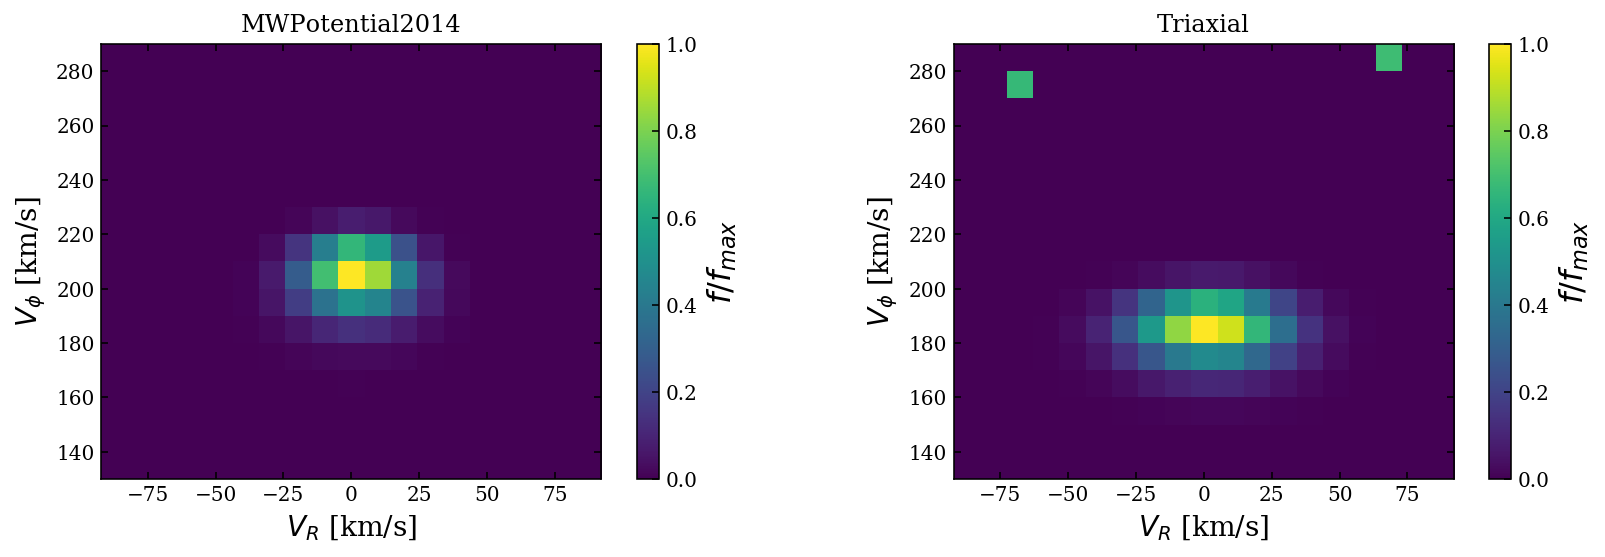

In [9]:
# Make the figure
fig = plt.figure( figsize=(14,4) )
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

# Plot
fig, ax1, ax2, cbar1, cbar2 = hist_df(df0, dfp, vR_low, vR_hi, vT_low, vT_hi, log=False)
# ax1.grid(color='w', linestyle='-', linewidth=1)
# ax2.grid(color='w', linestyle='-', linewidth=1)
plt.show()

# No output
pass;

- There are clearly problem areas at [-72,270] and [68,280]

## Zoom In 1
Manually make the grid of velocities around the problem area at [-72,270]

In [52]:
# Now manually make the grid around the problem area
dvT = 0.001
dvR = 0.001
vR_low = -72.005
vR_hi = -71.995
vT_low = 269.995
vT_hi = 270.005

# Generate the velocity distribution and DF arrays
df0, dfp, vR_range, vT_range = gen_vRvT_1D(dvT, dvR, vR_low, vR_hi, vT_low, vT_hi)

# Declare the orbit parameters
vxvv = [16.*apu.kpc, 
        0, # Leave blank, will be set in loop
        0, # Leave blank, will be set in loop
        0.*apu.kpc,
        0.*apu.km/apu.s,
        0.*apu.radian]

# Evaluate the DF
df0, dfp = eval_df(vxvv, times, tripot_grow, vR_range, vT_range, df0, dfp  )

100 independent velocities
10 Between vR=[-72.0,-72.0]
10 Between vR=[270.0,270.0]


[-72.005 -72.004 -72.003 -72.002 -72.001 -72.    -71.999 -71.998 -71.997
 -71.996]
[269.995 269.996 269.997 269.998 269.999 270.    270.001 270.002 270.003
 270.004]




A Jupyter Widget

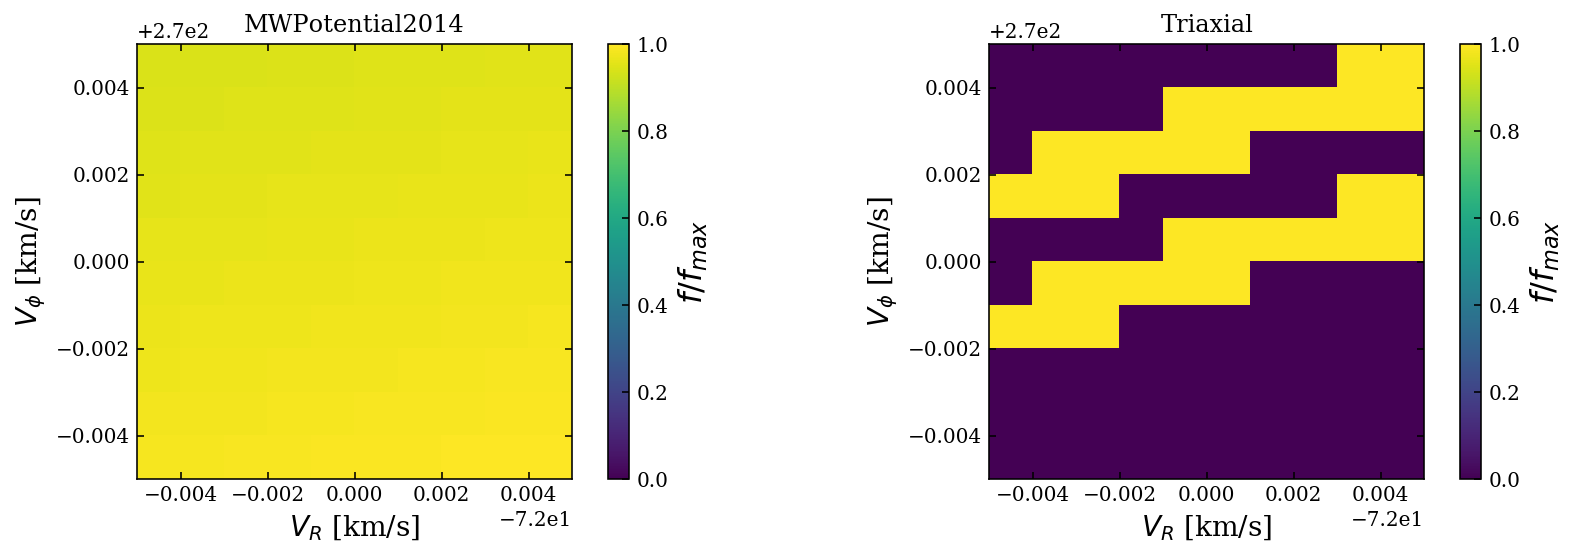

In [53]:
# Make the figure
fig = plt.figure( figsize=(14,4) )
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

# Plot
fig, ax1, ax2, cbar1, cbar2 = hist_df(df0, dfp, vR_low, vR_hi, vT_low, vT_hi, log=False)
plt.show()

# No output
pass;

### Evaluate the Actions
Calculate the actions to determine what's happening to the DF

A Jupyter Widget

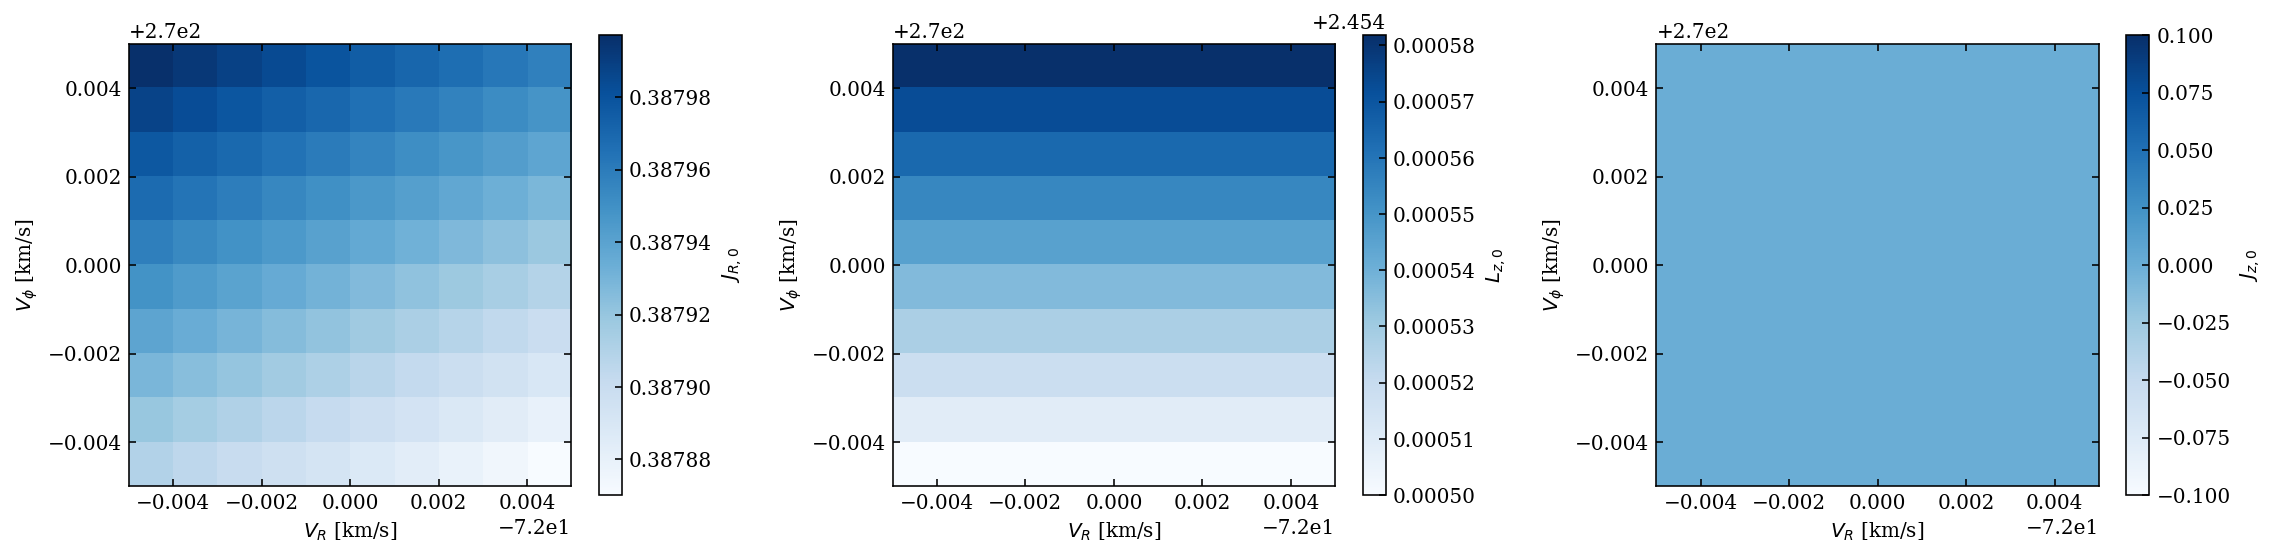

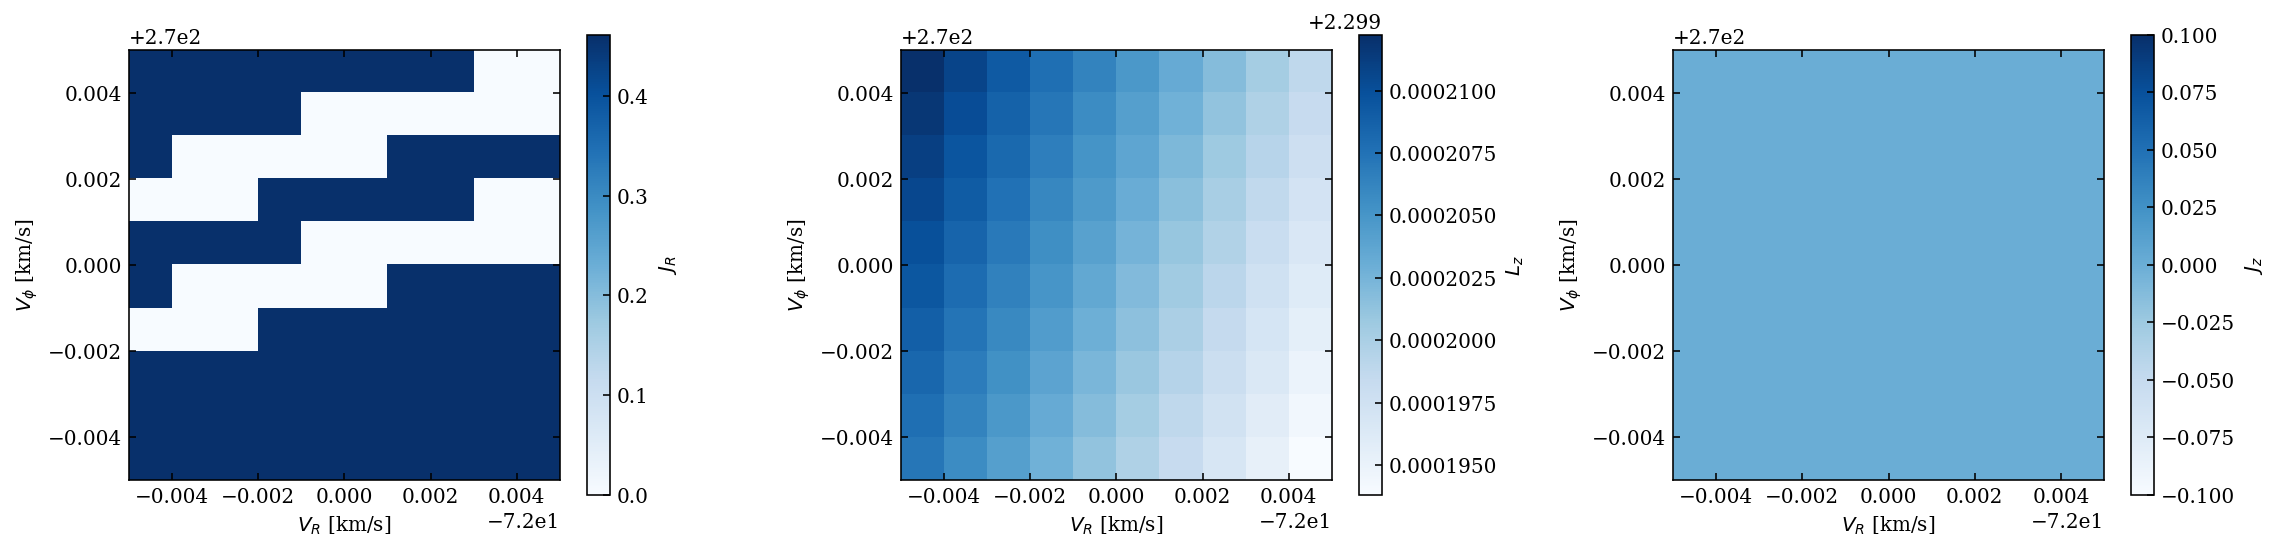

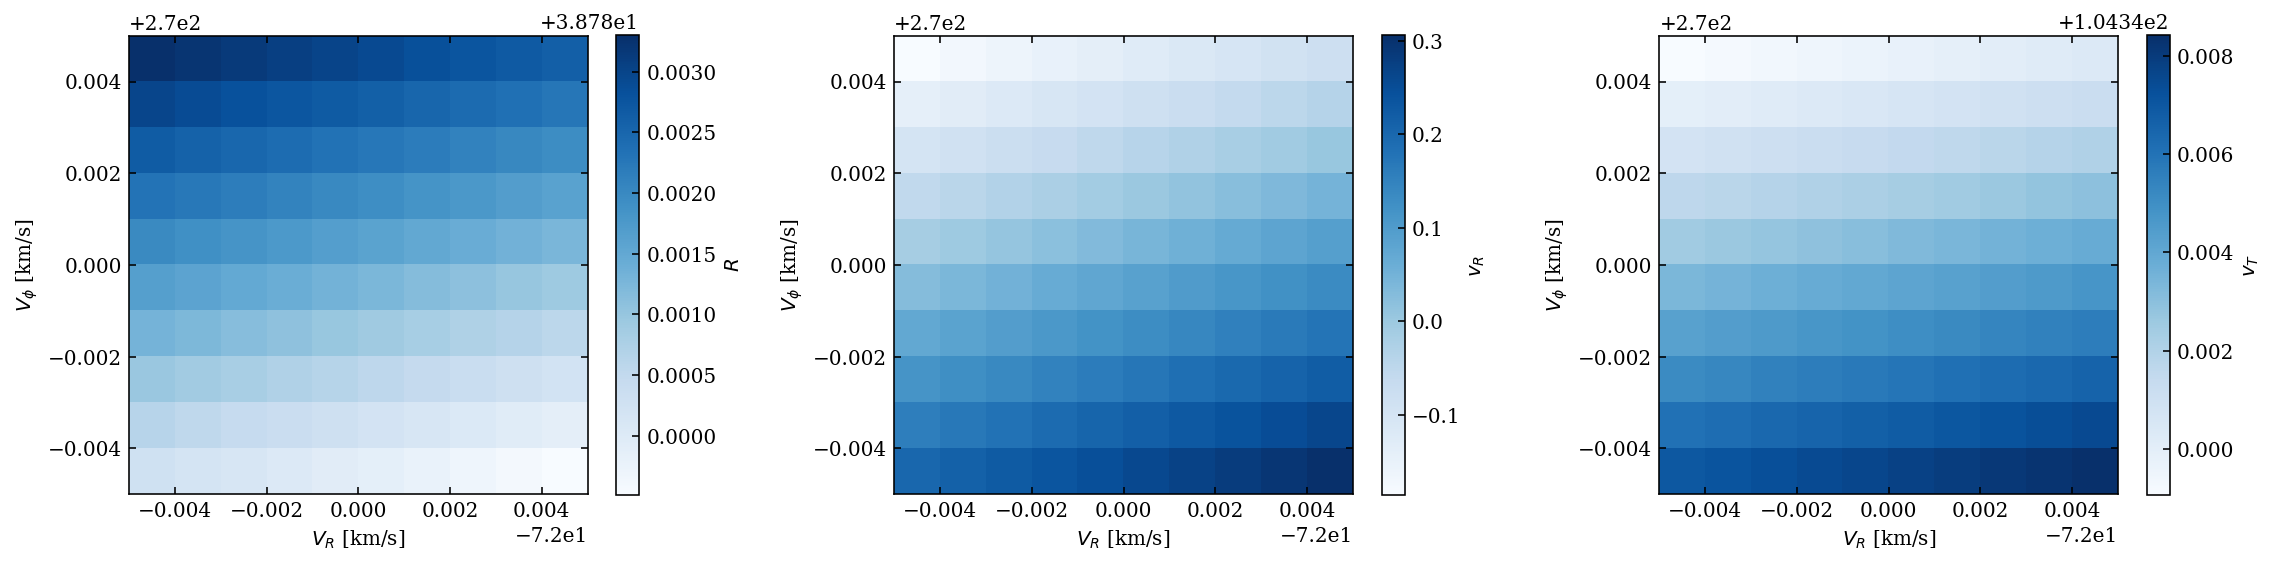

In [55]:
### Try plotting the actions, angles, & frequencies using the same grid as above:
act0 = np.zeros((3,len(vR_range),len(vT_range)))
actp = np.zeros((3,len(vR_range),len(vT_range)))

# Declare the orbit parameters
vxvv = [16.*apu.kpc, 
        0, # Leave blank, will be set in loop
        0, # Leave blank, will be set in loop
        0.*apu.kpc,
        0.*apu.km/apu.s,
        0.*apu.radian]

# Evaluate the actions
act0, actp, end_kin = eval_act(vxvv, times, tripot_grow, qdf_aA, vR_range, vT_range, act0, actp, return_kin=True )

# Plot the unperturbed actions
fig = plt.figure( figsize=(16,4) )
axs = fig.subplots(nrows=1, ncols=3)
cbar_labels = [r'$J_{R,0}$', r'$L_{z,0}$', r'$J_{z,0}$']
fig, axs = hist_act(act0, vR_low, vR_hi, vT_low, vT_hi, cbar_labels)
plt.tight_layout()
plt.show()
plt.close('all')

# Plot the perturbed actions
fig = plt.figure( figsize=(16,4) )
axs = fig.subplots(nrows=1, ncols=3)
cbar_labels = [r'$J_{R}$', r'$L_{z}$', r'$J_{z}$']
fig, axs = hist_act(actp, vR_low, vR_hi, vT_low, vT_hi, cbar_labels)
plt.tight_layout()
plt.show()
plt.close('all')

# Plot the ending kinematics used to calculate the actions
fig = plt.figure( figsize=(16,4) )
axs = fig.subplots(nrows=1, ncols=3)
cbar_labels = [r'$R$', r'$v_{R}$', r'$v_{T}$']
fig, axs = hist_act(end_kin, vR_low, vR_hi, vT_low, vT_hi, cbar_labels)
plt.tight_layout()
plt.show()
plt.close('all')

# Save outputs for checking later
where_bad_orbit = np.where( actp[0] == 0 )
outarr = end_kin[:,where_bad_orbit[0],where_bad_orbit[1]]
np.savetxt('bad_JR_end_kinematics1.csv', outarr.T, delimiter=',', header='# R_end, VR_end, VT_end')

# No output
pass;

## Zoom In 2
Manually make the grid of velocities around the problem area at [68,280]

In [56]:
# Now manually make the grid around the problem area
dvT = 0.001
dvR = 0.001
vR_low = 67.995
vR_hi = 68.005
vT_low = 279.995
vT_hi = 280.005

# Generate the velocity distribution and DF arrays
df0, dfp, vR_range, vT_range = gen_vRvT_1D(dvT, dvR, vR_low, vR_hi, vT_low, vT_hi)

# Declare the orbit parameters
vxvv = [16.*apu.kpc, 
        0, # Leave blank, will be set in loop
        0, # Leave blank, will be set in loop
        0.*apu.kpc,
        0.*apu.km/apu.s,
        0.*apu.radian]

# Evaluate the DF
df0, dfp = eval_df(vxvv, times, tripot_grow, vR_range, vT_range, df0, dfp  )

100 independent velocities
10 Between vR=[68.0,68.0]
10 Between vR=[280.0,280.0]


[67.995 67.996 67.997 67.998 67.999 68.    68.001 68.002 68.003 68.004]
[279.995 279.996 279.997 279.998 279.999 280.    280.001 280.002 280.003
 280.004]




A Jupyter Widget

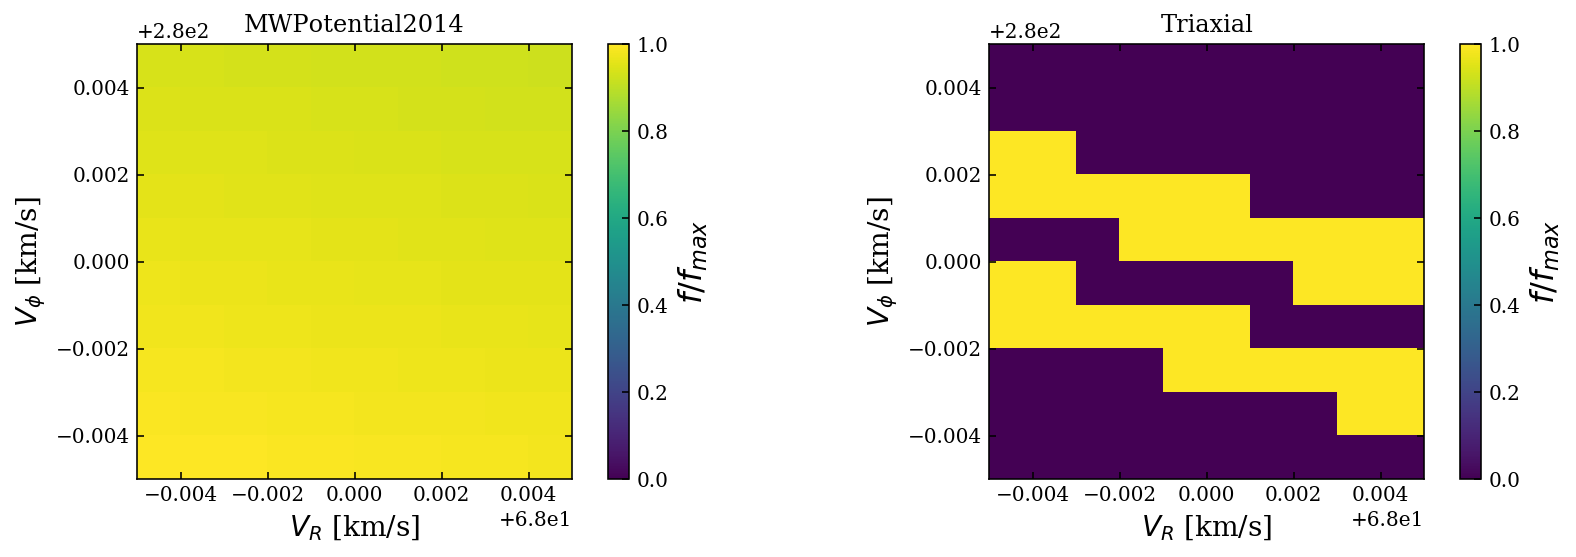

In [57]:
# Make the figure
fig = plt.figure( figsize=(14,4) )
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

# Plot
fig, ax1, ax2, cbar1, cbar2 = hist_df(df0, dfp, vR_low, vR_hi, vT_low, vT_hi, log=False)
plt.show()

# No output
pass;

### Evaluate the Actions
Calculate the actions to determine what's happening to the DF

A Jupyter Widget

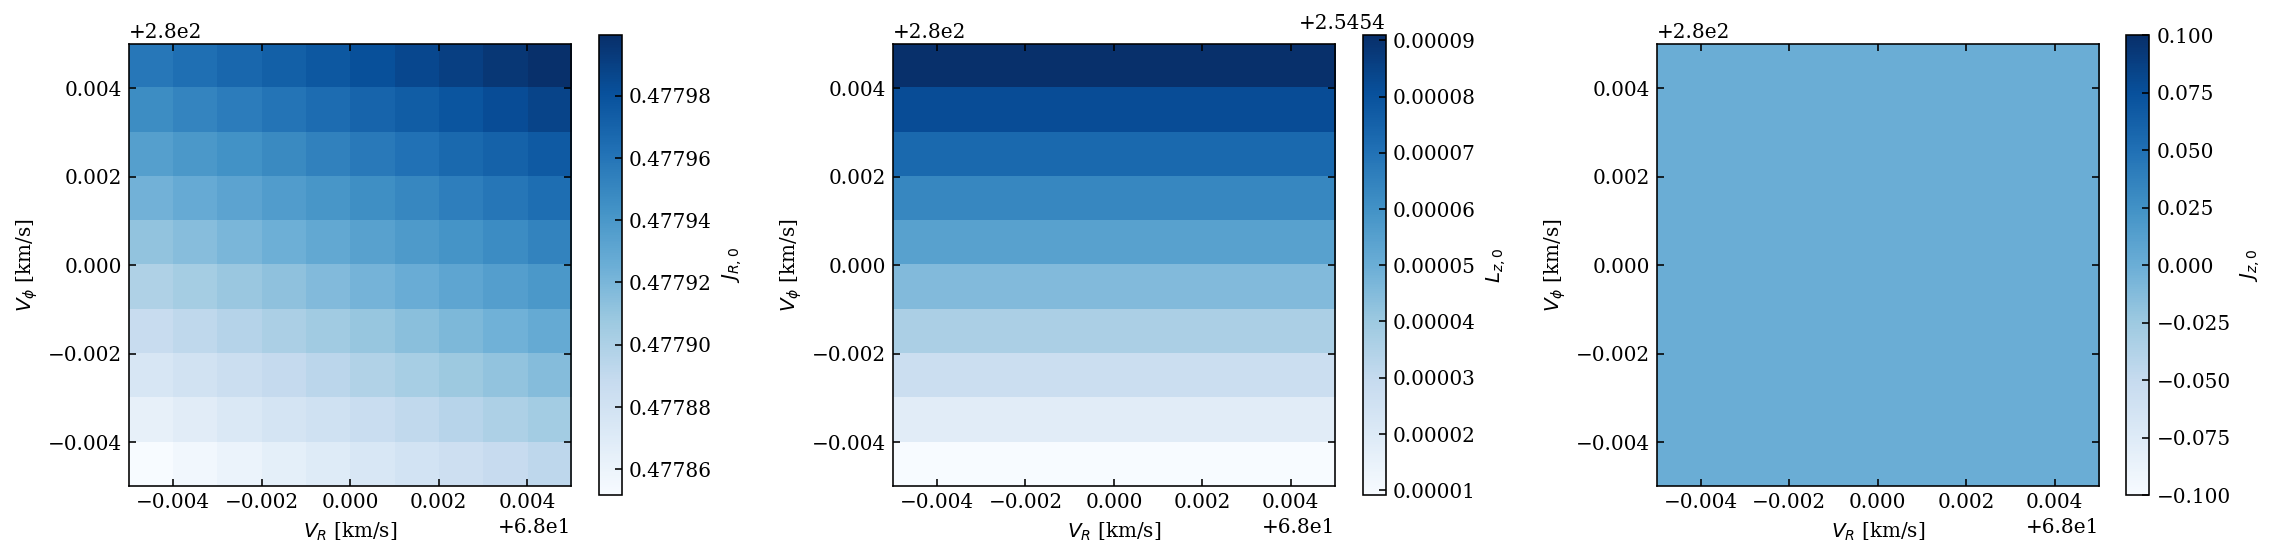

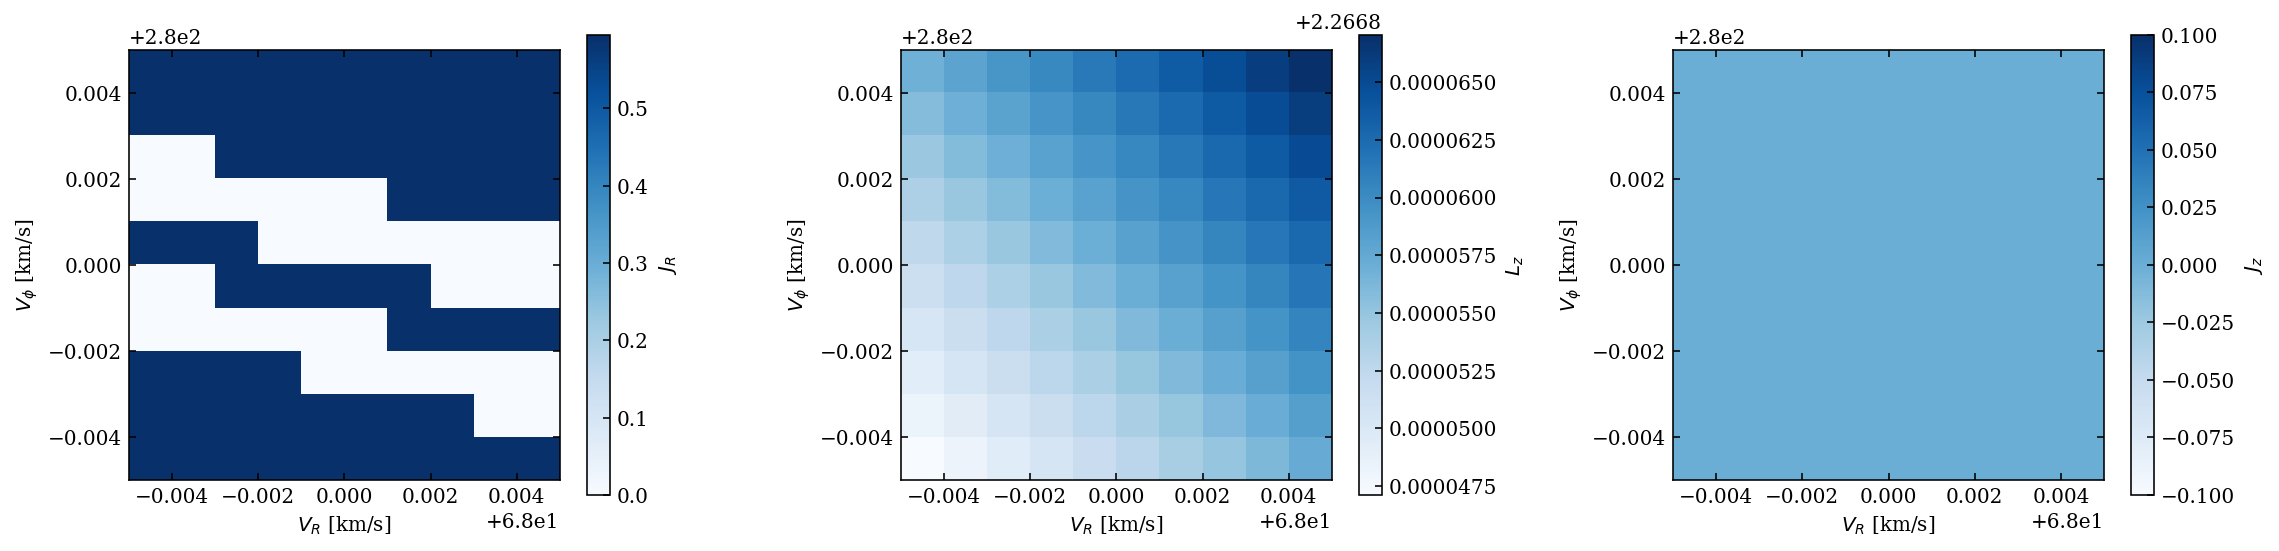

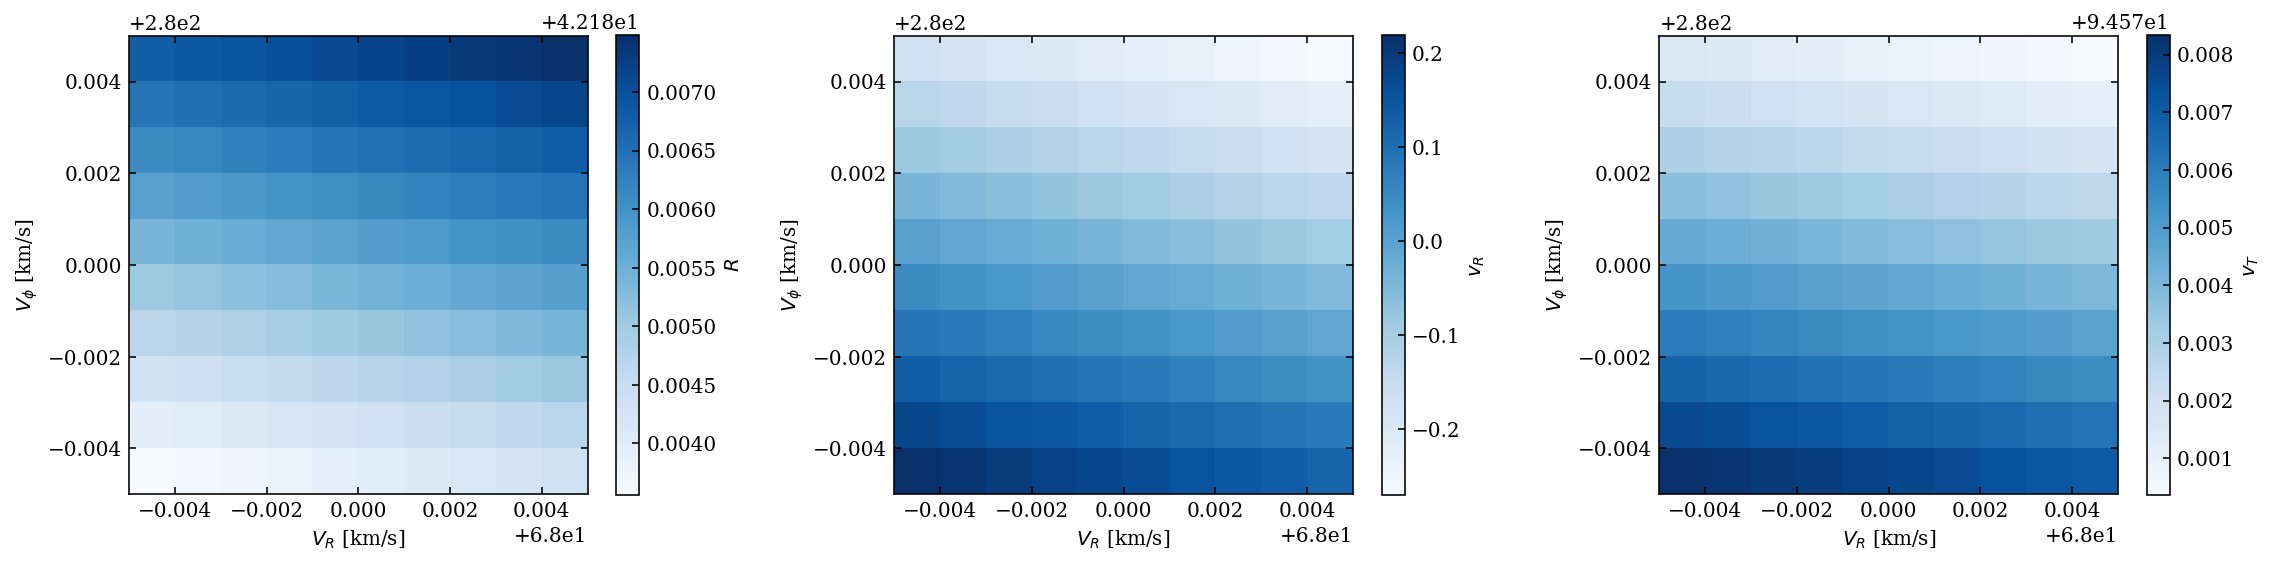

In [58]:
### Try plotting the actions, angles, & frequencies using the same grid as above:
act0 = np.zeros((3,len(vR_range),len(vT_range)))
actp = np.zeros((3,len(vR_range),len(vT_range)))

# Declare the orbit parameters
vxvv = [16.*apu.kpc, 
        0, # Leave blank, will be set in loop
        0, # Leave blank, will be set in loop
        0.*apu.kpc,
        0.*apu.km/apu.s,
        0.*apu.radian]

# Evaluate the actions
act0, actp, end_kin = eval_act(vxvv, times, tripot_grow, qdf_aA, vR_range, vT_range, act0, actp, return_kin=True )

# Plot the unperturbed actions
fig = plt.figure( figsize=(16,4) )
axs = fig.subplots(nrows=1, ncols=3)
cbar_labels = [r'$J_{R,0}$', r'$L_{z,0}$', r'$J_{z,0}$']
fig, axs = hist_act(act0, vR_low, vR_hi, vT_low, vT_hi, cbar_labels)
plt.tight_layout()
plt.show()
plt.close('all')

# Plot the perturbed actions
fig = plt.figure( figsize=(16,4) )
axs = fig.subplots(nrows=1, ncols=3)
cbar_labels = [r'$J_{R}$', r'$L_{z}$', r'$J_{z}$']
fig, axs = hist_act(actp, vR_low, vR_hi, vT_low, vT_hi, cbar_labels)
plt.tight_layout()
plt.show()
plt.close('all')

# Plot the ending kinematics used to calculate the actions
fig = plt.figure( figsize=(16,4) )
axs = fig.subplots(nrows=1, ncols=3)
cbar_labels = [r'$R$', r'$v_{R}$', r'$v_{T}$']
fig, axs = hist_act(end_kin, vR_low, vR_hi, vT_low, vT_hi, cbar_labels)
plt.tight_layout()
plt.show()
plt.close('all')

# Save outputs for checking later
where_bad_orbit = np.where( actp[0] == 0 )
outarr = end_kin[:,where_bad_orbit[0],where_bad_orbit[1]]
np.savetxt('bad_JR_end_kinematics2.csv', outarr.T, delimiter=',', header='# R_end, VR_end, VT_end')

# No output
pass;

### Plot Ending Orbit
Plot the orbital parameters at the end of the orbit to see if there is a trend

In [59]:
actp = np.zeros((3,len(vR_range),len(vT_range)))

jR_save = np.zeros(len(vR_range)*len(vT_range))
vR_save = np.zeros(len(vR_range)*len(vT_range))
vT_save = np.zeros(len(vR_range)*len(vT_range))
R_save = np.zeros(len(vR_range)*len(vT_range))

# Declare the orbit parameters
vxvv = [16.*apu.kpc, 
        0, # Leave blank, will be set in loop
        0, # Leave blank, will be set in loop
        0.*apu.kpc,
        0.*apu.km/apu.s,
        0.*apu.radian]

# Perform the loops
vxvv_use = copy.deepcopy(vxvv)
for j in tqdm_nb( range( len(vR_range) ) ):
    for k in range( len(vT_range) ):

        # Make the orbit
        vxvv_use[1] = vR_range[j]*apu.km/apu.s
        vxvv_use[2] = vT_range[k]*apu.km/apu.s
        o = orbit.Orbit(vxvv=vxvv_use)

        # Get the actions, angles and frequencies for the unperturbed orbit
        act0[0,j,k],act0[1,j,k],act0[2,j,k] = qdf_aA(o)

        # Integrate the orbit and evaluate 
        o.integrate(times, tripot_grow)
        actp[0,j,k],actp[1,j,k],actp[2,j,k] = qdf_aA( o(times[-1]) )
        
        jR_save[int(j*len(vT_range)+k)] = actp[0,j,k]
        vR_save[int(j*len(vT_range)+k)] = o.vR(times[-1]).value
        vT_save[int(j*len(vT_range)+k)] = o.vT(times[-1]).value
        R_save[int(j*len(vT_range)+k)] = o.R(times[-1]).value
    ###k
###j

A Jupyter Widget

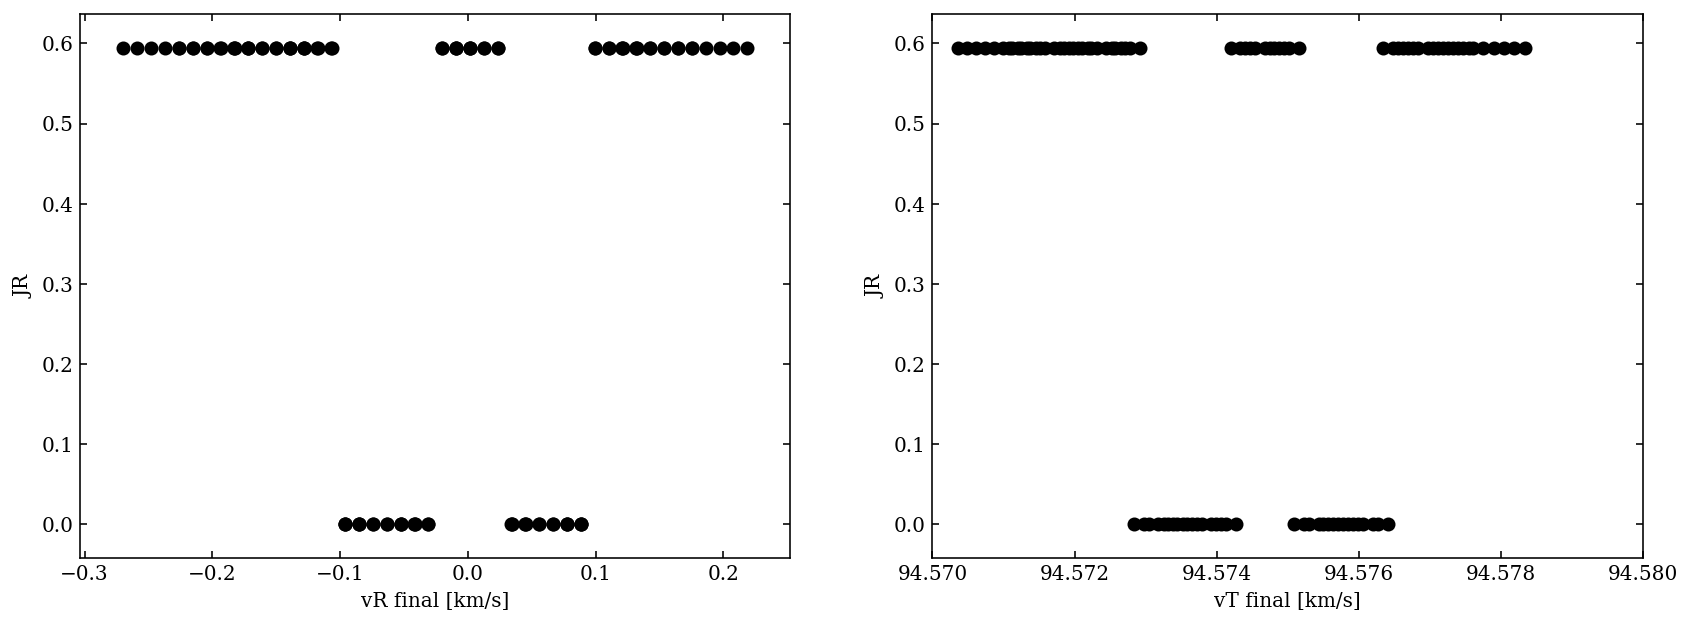

In [60]:
fig = plt.figure(figsize=(14,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.scatter(vR_save, jR_save, color='Black')
ax2.scatter(vT_save, jR_save, color='Black')

ax1.set_xlabel('vR final [km/s]')
ax1.set_ylabel('JR')
ax2.set_xlabel('vT final [km/s]')
ax2.set_ylabel('JR')
ax2.set_xlim(94.57,94.58)

plt.show()
plt.close('all')

# No output
pass;

# Trial 2 - Changing Position Angle
$ R=8 $ kpc and $z=0$ kpc

In [10]:
### Make MWPotential2014
mwpot = potential.MWPotential2014

### Make the triaxial halo
halo_phi = np.linspace(0, np.pi/2, 5)[3]
trihalo = ast1501.potential.make_MWPotential2014_triaxialNFW(halo_b=2.0, halo_phi=halo_phi, halo_c=1.0)

### Make MWPotential2014 with DSW around the halo and triaxial halo
tripot_grow = ast1501.potential.make_tripot_dsw(trihalo=trihalo, tform=tform, tsteady=tsteady)
potential.turn_physical_off(tripot_grow)

In [11]:
# Now make the grid for our velocities, which will span 2sigma (approx) in each of R,T,Z velocities
# Manually set ranges for clean dV
dvT = 10.
dvR = 10.
vR_low = -100
vR_hi = 100
vT_low = 100
vT_hi = 300

# Generate the velocity distribution and DF arrays
df0, dfp, vR_range, vT_range = gen_vRvT_1D(dvT, dvR, vR_low, vR_hi, vT_low, vT_hi)

# Declare the orbit parameters
vxvv = [8.*apu.kpc, 
        0, # Leave blank, will be set in loop
        0, # Leave blank, will be set in loop
        0.*apu.kpc,
        0.*apu.km/apu.s,
        0.*apu.radian]

# Evaluate the DF
df0, dfp = eval_df(vxvv, times, tripot_grow, vR_range, vT_range, df0, dfp  )

400 independent velocities
20 Between vR=[-100.0,90.0]
20 Between vR=[100.0,290.0]


[-100.  -90.  -80.  -70.  -60.  -50.  -40.  -30.  -20.  -10.    0.   10.
   20.   30.   40.   50.   60.   70.   80.   90.]
[100. 110. 120. 130. 140. 150. 160. 170. 180. 190. 200. 210. 220. 230.
 240. 250. 260. 270. 280. 290.]




A Jupyter Widget

/Users/JamesLane/Software/Python/anaconda3/envs/ast1501-dev/lib/python3.6/site-packages/galpy/df/quasiisothermaldf.py:281: RuntimeWarning: overflow encountered in exp
  *numpy.exp(-kappa*jr*srm2)

/Users/JamesLane/Software/Python/anaconda3/envs/ast1501-dev/lib/python3.6/site-packages/galpy/df/quasiisothermaldf.py:281: RuntimeWarning: invalid value encountered in multiply
  *numpy.exp(-kappa*jr*srm2)




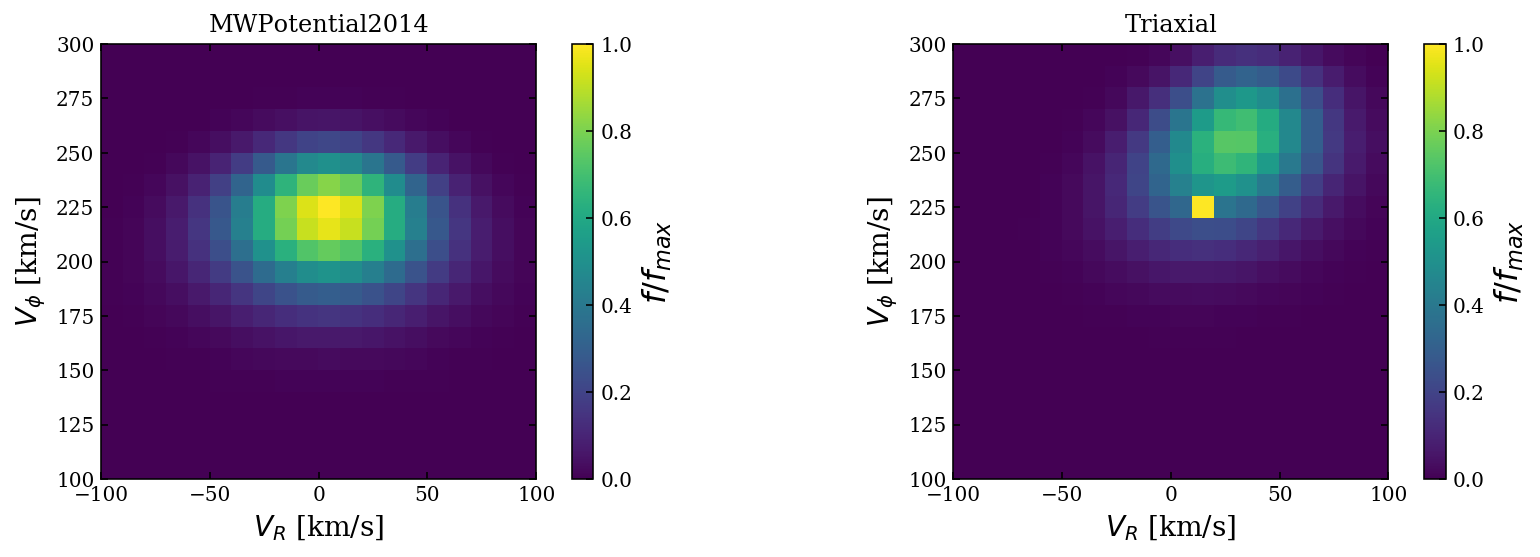

In [12]:
# Make the figure
fig = plt.figure( figsize=(14,4) )
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

# Plot
fig, ax1, ax2, cbar1, cbar2 = hist_df(df0, dfp, vR_low, vR_hi, vT_low, vT_hi, log=False)
plt.show()

# No output
pass;

In [13]:
## Where exactly does this feature appear
vR_range
vT_range
dfp.shape
np.max(dfp)
np.where(dfp>1640)

array([-100.,  -90.,  -80.,  -70.,  -60.,  -50.,  -40.,  -30.,  -20.,
        -10.,    0.,   10.,   20.,   30.,   40.,   50.,   60.,   70.,
         80.,   90.])

array([100., 110., 120., 130., 140., 150., 160., 170., 180., 190., 200.,
       210., 220., 230., 240., 250., 260., 270., 280., 290.])

(20, 20)

1640.5918133344644

(array([11]), array([12]))

In [14]:
vxvv_use = copy.copy(vxvv)
vxvv_use[1] = 10.*apu.km/apu.s
vxvv_use[2] = 220.*apu.km/apu.s
o = orbit.Orbit(vxvv=vxvv_use)
o.integrate(times, tripot_grow)
qdf( o(times[-1]) )

array([1640.59181333])

## Zoom In 3
Manually make the grid of velocities around the problem area at [10,220]

In [15]:
# Now manually make the grid around the problem area
dvT = 0.001
dvR = 0.001
vR_low = 9.990
vR_hi = 10.000
vT_low = 219.995
vT_hi = 220.005

# Generate the velocity distribution and DF arrays
df0, dfp, vR_range, vT_range = gen_vRvT_1D(dvT, dvR, vR_low, vR_hi, vT_low, vT_hi)

# Declare the orbit parameters
vxvv = [8.*apu.kpc, 
        0, # Leave blank, will be set in loop
        0, # Leave blank, will be set in loop
        0.*apu.kpc,
        0.*apu.km/apu.s,
        0.*apu.radian]

# Evaluate the DF
df0, dfp = eval_df(vxvv, times, tripot_grow, vR_range, vT_range, df0, dfp  )

100 independent velocities
10 Between vR=[10.0,10.0]
10 Between vR=[220.0,220.0]


[9.99  9.991 9.992 9.993 9.994 9.995 9.996 9.997 9.998 9.999]
[219.995 219.996 219.997 219.998 219.999 220.    220.001 220.002 220.003
 220.004]




A Jupyter Widget

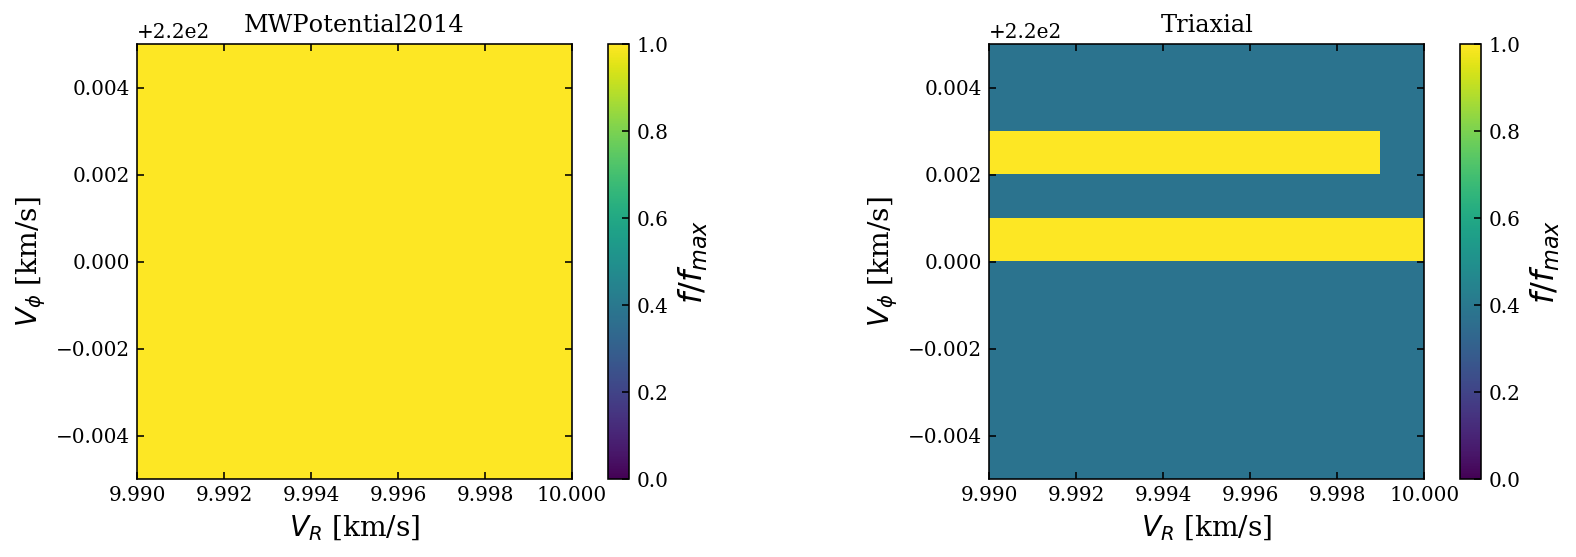

In [16]:
# Make the figure
fig = plt.figure( figsize=(14,4) )
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

# Plot
fig, ax1, ax2, cbar1, cbar2 = hist_df(df0, dfp, vR_low, vR_hi, vT_low, vT_hi, log=False)
plt.show()

# No output
pass;

### Evaluate the Actions
Calculate the actions to determine what's happening to the DF

A Jupyter Widget

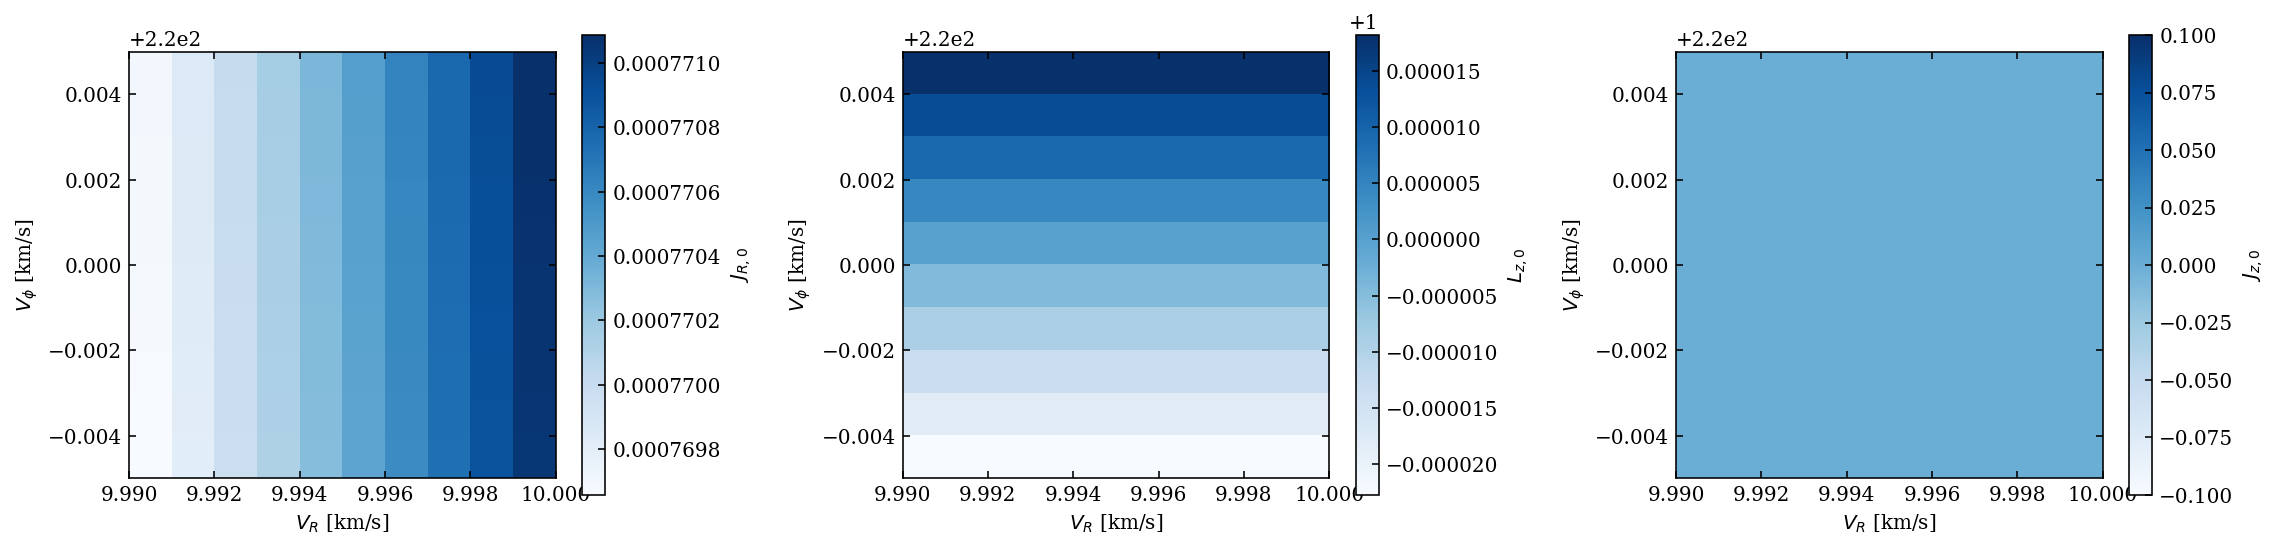

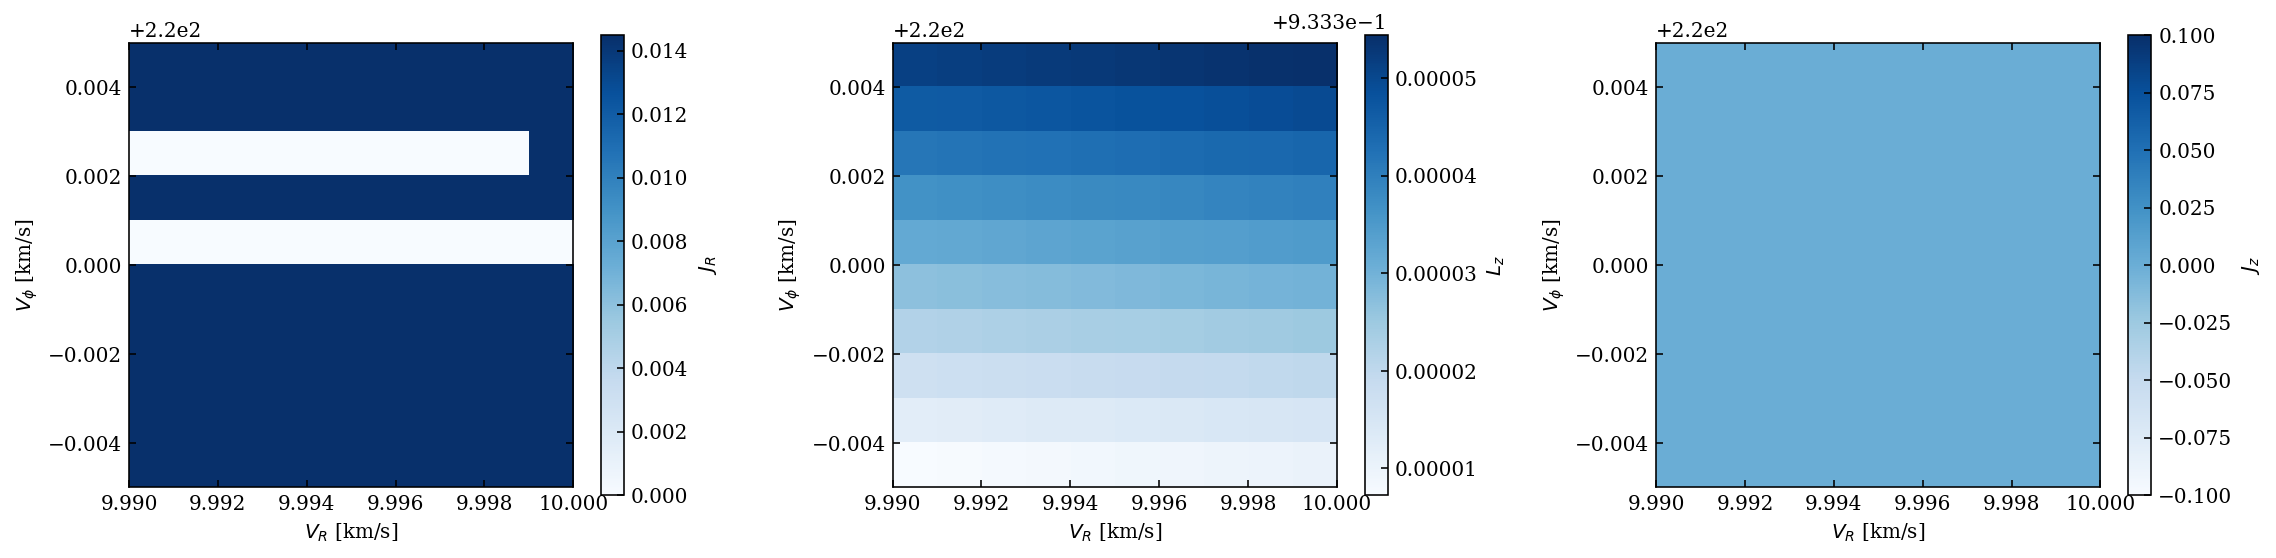

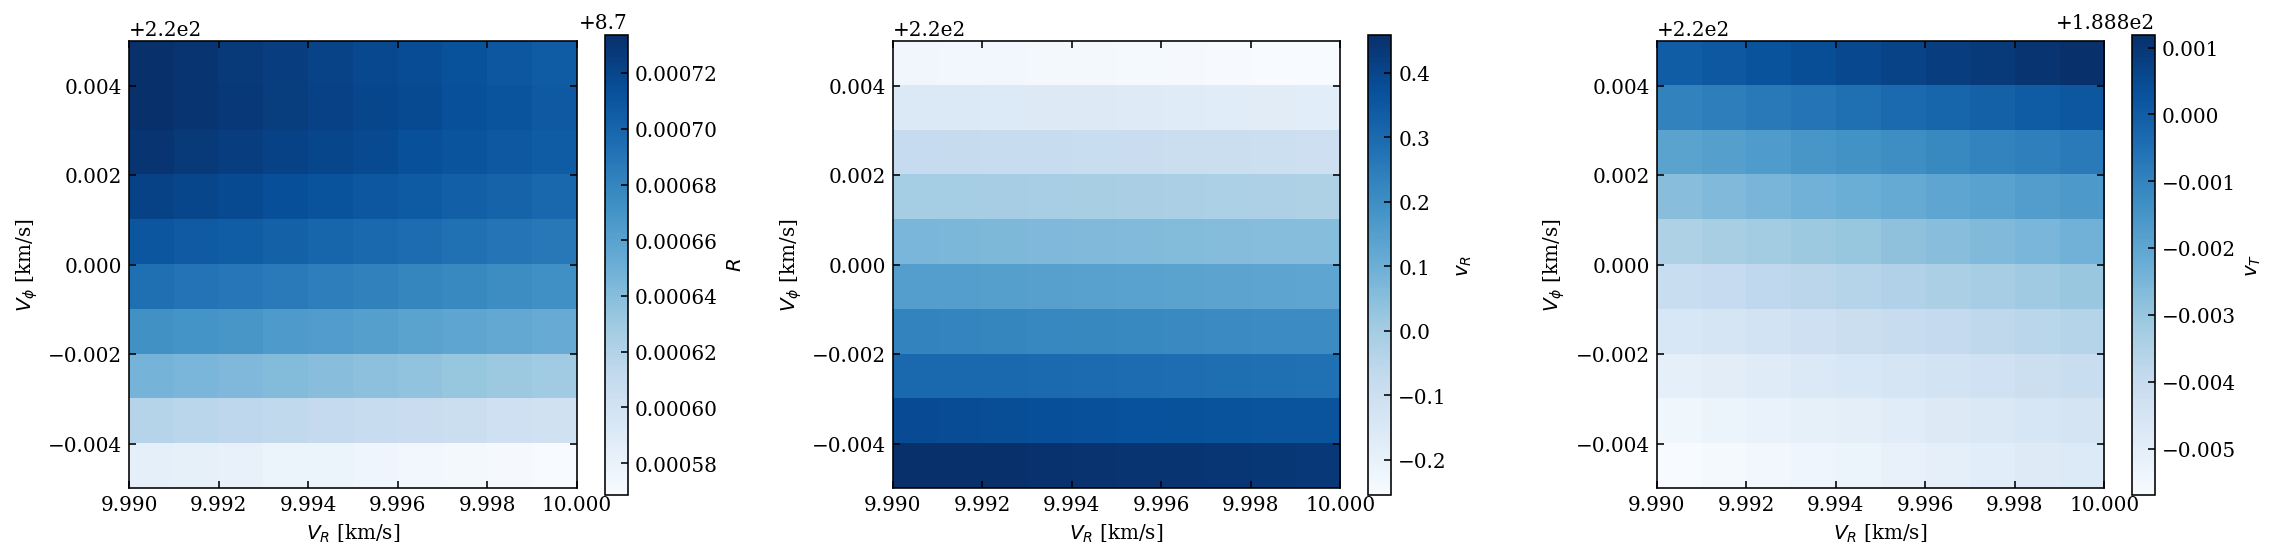

In [17]:
### Try plotting the actions, angles, & frequencies using the same grid as above:
act0 = np.zeros((3,len(vR_range),len(vT_range)))
actp = np.zeros((3,len(vR_range),len(vT_range)))

# Declare the orbit parameters
vxvv = [8.*apu.kpc, 
        0, # Leave blank, will be set in loop
        0, # Leave blank, will be set in loop
        0.*apu.kpc,
        0.*apu.km/apu.s,
        0.*apu.radian]

# Evaluate the actions
act0, actp, end_kin = eval_act(vxvv, times, tripot_grow, qdf_aA, vR_range, vT_range, act0, actp, return_kin=True )

# Plot the unperturbed actions
fig = plt.figure( figsize=(16,4) )
axs = fig.subplots(nrows=1, ncols=3)
cbar_labels = [r'$J_{R,0}$', r'$L_{z,0}$', r'$J_{z,0}$']
fig, axs = hist_act(act0, vR_low, vR_hi, vT_low, vT_hi, cbar_labels)
plt.tight_layout()
plt.show()
plt.close('all')

# Plot the perturbed actions
fig = plt.figure( figsize=(16,4) )
axs = fig.subplots(nrows=1, ncols=3)
cbar_labels = [r'$J_{R}$', r'$L_{z}$', r'$J_{z}$']
fig, axs = hist_act(actp, vR_low, vR_hi, vT_low, vT_hi, cbar_labels)
plt.tight_layout()
plt.show()
plt.close('all')

# Plot the ending kinematics used to calculate the actions
fig = plt.figure( figsize=(16,4) )
axs = fig.subplots(nrows=1, ncols=3)
cbar_labels = [r'$R$', r'$v_{R}$', r'$v_{T}$']
fig, axs = hist_act(end_kin, vR_low, vR_hi, vT_low, vT_hi, cbar_labels)
plt.tight_layout()
plt.show()
plt.close('all')

# Save outputs for checking later
where_bad_orbit = np.where( actp[0] == 0 )
outarr = end_kin[:,where_bad_orbit[0],where_bad_orbit[1]]
np.savetxt('bad_JR_end_kinematics2.csv', outarr.T, delimiter=',', header='# R_end, VR_end, VT_end')

# No output
pass;

### Plot Ending Orbit
Plot the orbital parameters at the end of the orbit to see if there is a trend

In [18]:
actp = np.zeros((3,len(vR_range),len(vT_range)))

jR_save = np.zeros(len(vR_range)*len(vT_range))
vR_save = np.zeros(len(vR_range)*len(vT_range))
vT_save = np.zeros(len(vR_range)*len(vT_range))
R_save = np.zeros(len(vR_range)*len(vT_range))

# Declare the orbit parameters
vxvv = [8.*apu.kpc, 
        0, # Leave blank, will be set in loop
        0, # Leave blank, will be set in loop
        0.*apu.kpc,
        0.*apu.km/apu.s,
        0.*apu.radian]

# Perform the loops
vxvv_use = copy.deepcopy(vxvv)
for j in tqdm_nb( range( len(vR_range) ) ):
    for k in range( len(vT_range) ):

        # Make the orbit
        vxvv_use[1] = vR_range[j]*apu.km/apu.s
        vxvv_use[2] = vT_range[k]*apu.km/apu.s
        o = orbit.Orbit(vxvv=vxvv_use)

        # Get the actions, angles and frequencies for the unperturbed orbit
        act0[0,j,k],act0[1,j,k],act0[2,j,k] = qdf_aA(o)

        # Integrate the orbit and evaluate 
        o.integrate(times, tripot_grow)
        actp[0,j,k],actp[1,j,k],actp[2,j,k] = qdf_aA( o(times[-1]) )
        
        jR_save[int(j*len(vT_range)+k)] = actp[0,j,k]
        vR_save[int(j*len(vT_range)+k)] = o.vR(times[-1]).value
        vT_save[int(j*len(vT_range)+k)] = o.vT(times[-1]).value
        R_save[int(j*len(vT_range)+k)] = o.R(times[-1]).value
    ###k
###j

A Jupyter Widget

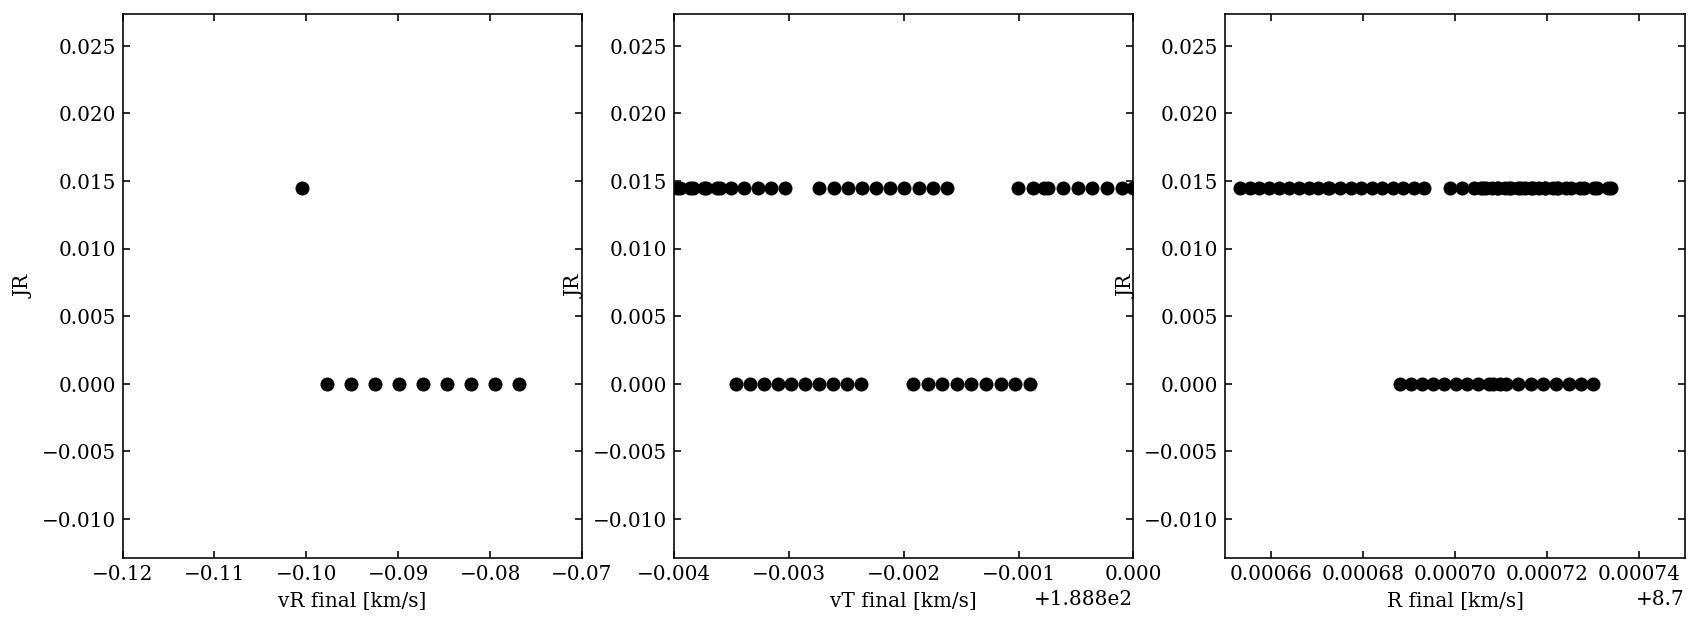

In [32]:
fig = plt.figure(figsize=(14,5))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.scatter(vR_save, jR_save, color='Black')
ax2.scatter(vT_save, jR_save, color='Black')
ax3.scatter(R_save, jR_save, color='Black')

ax1.set_xlabel('vR final [km/s]')
ax1.set_ylabel('JR')
ax1.set_xlim(-0.12,-0.07)

ax2.set_xlabel('vT final [km/s]')
ax2.set_ylabel('JR')
ax2.set_xlim(188.796, 188.8)

ax3.set_xlabel('R final [km/s]')
ax3.set_ylabel('JR')
ax3.set_xlim(8.70065,8.70075)

plt.show()
plt.close('all')

# No output
pass;

***

# Summary of findings
- The exact spacing of the input grid is what determines whether you are going to get a strange output feature
- The input features have strange structure at the m/s scale
- Changing z changes the location of the feature